<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Assembly_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Assembly of small genomes</h1>

This tutorial aims to demonstrate how to assemble and correct small genomes, up to ~100Mb, using Oxford Nanopore Technologies' sequencing data.

Included with the tutorial is an example Escherichia coli dataset, the workflow can be used to:

* Assemble sequencing data in a `.fastq` file into a genomic sequence using the [`flye`](https://github.com/fenderglass/Flye) assembler
* Correct the genome assembly using the [`medaka`](https://github.com/nanoporetech/medaka) software
* Perform a basic summary of the assembled genome

Computational requirements for this tutorial include:

- Computer running the **EPI2ME Labs** notebook Server
- At least 16 Gb RAM

⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.

## Data preparation

To start analysing our experiment we must first collate our data. The workflow below expects to be given a single `.fastq` file containing all the sequencing data which is to be assembled. If you have multiple `.fastq` files which need to first be aggregated, see our [Introduction to `.fastq`](https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/fastq_introduction.ipynb) notebook.

⚠️ ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See Run a tutorial on the EPI2ME Labs Server help page for more information.

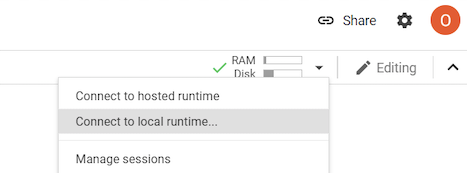

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [ ]:
# create a work directory and move into it
tutorial_name = "assembly_tutorial"
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'assembly_tutorial')

/epi2melabs/assembly_tutorial


201

### Sample Data

To get started we will download a sample sequencing dataset. The data comprise sequencing reads, from an R10.3 flowcell, of a bacterial mock community. Two preprocessed sets are available:

* ***larger***: reads from the experiment were filtered (by alignment to reference sequences) to only be reads derived from an Escherichia coli genome, and then downsampled to approximately 60x coverage of the genome.
* ***small***: reads were additionally filtered to 30x coverage.

To use this tutorial with sample data we can download the files using the `linux` command `wget`. To execute the commands to download the data select the dataset you wish to download and then click the Play symbol to the left-hand side. (To see the code responsible for downloading the dataset double click the bold title text).


In [ ]:
#@markdown **Select download type and press Play**
dataset = "smaller (30x)" #@param ["smaller (30x)", "larger (60x)"]
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

downloads = {
    "smaller (30x)": "ecoli.30x.r103.fastq.gz",
    "larger (60x)": "ecoli.60x.r103.fastq.gz"}

## download the data
location = '{}/assembly_tutorial'.format(site)
fname = downloads[dataset]
print("Downloading {} dataset...".format(dataset))
!wget "$location/$fname"
!mv "$fname" sample_data.fastq.gz

--2020-04-22 12:42:25--  https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com/assembly_tutorial/ecoli.30x.r103.fastq.gz
Resolving ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com)... 52.218.108.120
Connecting to ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com)|52.218.108.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153286611 (146M) [binary/octet-stream]
Saving to: ‘ecoli.30x.r103.fastq.gz’

ecoli.30x.r103.fast 100%[===================>] 146.18M  4.07MB/s    in 38s     

2020-04-22 12:43:03 (3.83 MB/s) - ‘ecoli.30x.r103.fastq.gz’ saved [153286611/153286611]



To view the outcome of the download we can use the `tree` command to show the contents of the working directory:

In [ ]:
!tree .

.
└── sample_data.fastq.gz

0 directories, 1 file


The files should also appear in the File Browser to the left-hand side of the screen.

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `data_folder` variable below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

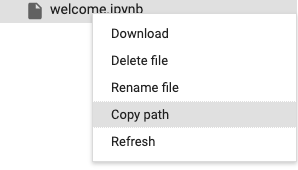

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.


### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below, after updating the values, be sure to press the play button.



> **If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run after` from the `Runtime` menu above after executing the cell below.**

In [ ]:
#@markdown Enter the paths to you input files and output folder here. The input data may be either a a single fastq, compressed or otherwise, file or a directory containing multiple such files:
import os

# set variables for our inputs
input_data = 'sample_data.fastq.gz'  #@param {type: "string"}
output_folder = 'analysis'  #@param {type: "string"}
input_fastq = os.path.join(output_folder, "input.fastq.gz")

# run a command to concatenate all the files together
!echo "Making output folder"
!mkdir -p "$output_folder"
!rationalise_fastq -i "$input_data" -o "$input_fastq"

Making output folder
Input: /epi2melabs/assembly_tutorial/sample_data.fastq.gz
Output: /epi2melabs/assembly_tutorial/analysis/input.fastq.gz
Output exists, exiting


## Basic Assembly with Flye

For small to mid-sized genomes, and meta-genomic applications, Oxford Nanopore Technologies' recommends the use of the [flye](https://github.com/fenderglass/Flye) assembler. Flye yields acceptable assembly results under a range of input conditions with little to no tuning from the user.

Oxford Nanopore Technologies also work with two other common assemblers:

*   [canu](https://github.com/marbl/canu), a recommended option when runtime contraints are not an issue. Reliably produces good assemblies
*   [shasta](https://github.com/chanzuckerberg/shasta), an assembler for the connoisseur. Very fast assembler that can produce state of the art results but can require manual tuning of parameters for optimal results.



### Genome assembly

The flye assembler has a relatively compact set of options, and is easily run with an input `.fastq` file. To run the assembly execute the cell below. A genome size estimate is required (for example, "5m" and "2.6g" should be given for genomes of sizes 5 mega-bases and 2.6 giga-bases respectively), the code can be edited before running. The `--threads` option specifies the amount of CPU resource that will be used. On a mid-range contemporary laptop the assembly will take around 30 minutes. For maximum performance set this option to the number of CPU cores available on your computer.

In [ ]:
!flye --nano-raw "$input_fastq" --out-dir "$output_folder"/flye --genome-size 5m --threads 8

[2020-05-06 14:19:05] INFO: Starting Flye 2.7.1-b1590
[2020-05-06 14:19:05] INFO: >>>STAGE: configure
[2020-05-06 14:19:05] INFO: Configuring run
[2020-05-06 14:19:07] INFO: Total read length: 142930802
[2020-05-06 14:19:07] INFO: Input genome size: 5000000
[2020-05-06 14:19:07] INFO: Estimated coverage: 28
[2020-05-06 14:19:07] INFO: Reads N50/N90: 23848 / 2656
[2020-05-06 14:19:07] INFO: Minimum overlap set to 3000
[2020-05-06 14:19:07] INFO: Selected k-mer size: 15
[2020-05-06 14:19:07] INFO: >>>STAGE: assembly
[2020-05-06 14:19:07] INFO: Assembling disjointigs
[2020-05-06 14:19:07] INFO: Reading sequences
[2020-05-06 14:19:09] INFO: Generating solid k-mer index
[2020-05-06 14:19:20] INFO: Counting k-mers (1/2):
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2020-05-06 14:19:23] INFO: Counting k-mers (2/2):
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2020-05-06 14:19:28] INFO: Filling index table
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2020-05-06 14:19:37] INFO: Extending rea

Providing flye runs to completion it will have output some basic statistics of the assembly, for example the sample data should give:

```
Total length:   4897024
Fragments:      3
Fragments N50:  4775934
Largest frg:    4775934
Scaffolds:      0
Mean coverage:  28
```

The expectation for bacterial genomes is to obtain a single `fragment` corresponding to a whole chromosome. For larger genomes this might not always occur depending on the sequencing depth and complexity of the genome.



### Error correcting the assembly

The flye assembler creates a reasonable quality consensus sequence from the aggregate information contained within the sequencing reads. However for improved accuracy it is recommended to run "assembly polishing," a process to correct residual base-level errors in the reads. This step will not change the gross structure of the assembly. To perform assembly polishing we will use the [medaka](https://github.com/nanoporetech/medaka) program. Medaka uses a [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network) to predict a consensus sequence from a pileup of reads aligned to a draft sequence.

Medaka contains a simple program for processing a draft assembly and read data. A particular point to note however is that it must be instructed which basecaller version and flowcell type (and so pore type) were used in the sequencing experiment; which model to use. A list of models can be found by running:

In [ ]:
!run medaka tools list_models

Available: r941_min_high_g330, r941_min_high_g344, r941_min_high_g351, r941_prom_high_g330, r941_prom_high_g344, r941_prom_high_g351, r941_min_high_g340_rle, r103_min_high_g345, r941_prom_snp_g322, r941_prom_variant_g322, r103_prom_snp_g3210, r103_prom_variant_g3210
Default consensus:  r941_min_high_g351
Default SNP:  r941_prom_snp_g322
Default variant:  r941_prom_variant_g322


As a reminder the correspondence between flowcell type and pore type is:

Flowcell | Pore type | Medaka model prefix
--- | --- | ---
FLO-MIN106D | R9.4.1 | `r941_min`
FLO-MIN111  | R10.3  | `r103_min`
FLO-PRO002  | R9.4.1 | `r941_prom`




For more information on choosing the correct model see the [Sequence Correction](https://nanoporetech.github.io/medaka/installation.html#sequence-correction) section of the medaka documentation.

> ⚠️ **Note:** Be sure to edit the code below to use the correct model (`-m` option) for your data.

In [ ]:
!run medaka_consensus \
    -d "$output_folder"/flye/assembly.fasta -i "$input_fastq" \
    -o "$output_folder"/medaka \
    -t 8 -m r103_min_high_g345

pinger.send_notebook_ping('stop', 'assembly_tutorial')

When medaka has run to completion it will output a file `consensus.fasta` in its output directory. This file contains the polished assembly sequences.

## Genome quality assessment

As a brief demonstration that things have gone well for the sample data provided with the tutorial, we will now compare the assembly sequence to a reference sequence for the analyte used in the experiment. A more in depth look at assessing assembly accuracy can be found in the links below.

A set of reference sequences for the analyte used in the sample data experiment can be downloaded using `wget`, this file contains reference sequence for all the mock community samples in the experiment:

In [ ]:
!wget 'https://ont-research.s3-eu-west-1.amazonaws.com/datasets/r941_zymo/references.fasta'

--2020-04-22 12:55:12--  https://ont-research.s3-eu-west-1.amazonaws.com/datasets/r941_zymo/references.fasta
Resolving ont-research.s3-eu-west-1.amazonaws.com (ont-research.s3-eu-west-1.amazonaws.com)... 52.218.98.192
Connecting to ont-research.s3-eu-west-1.amazonaws.com (ont-research.s3-eu-west-1.amazonaws.com)|52.218.98.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74187102 (71M) [binary/octet-stream]
Saving to: ‘references.fasta’

references.fasta    100%[===================>]  70.75M  4.27MB/s    in 19s     

2020-04-22 12:55:31 (3.79 MB/s) - ‘references.fasta’ saved [74187102/74187102]



### Pomoxis quality analysis

The `assess_assembly` program from the [pomoxis](https://github.com/nanoporetech/pomoxis) suite can be used to obtain an alignment-based quality analysis of a genome assembly. The basic workflow is to split assembly contigs into fixed lenth chunks before aligning these to a reference sequence. These alignments are then analysed for errors.

To run `assess_assembly` only two arguments are required, a reference sequence and the assembly. The `-p` option below sets an output prefix, while `-t` sets the number of compute threads:

In [ ]:
!mkdir -p analysis/assessment/
!assess_assembly -r references.fasta -i analysis/medaka/consensus.fasta \
    -p analysis/assessment/assm -t 8

Constructing minimap index.
[M::mm_idx_gen::1.334*1.32] collected minimizers
[M::mm_idx_gen::1.670*1.66] sorted minimizers
[M::main::2.088*1.53] loaded/built the index for 7217 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 7217
[M::mm_idx_stat::2.169*1.51] distinct minimizers: 11519899 (87.04% are singletons); average occurrences: 1.186; average spacing: 5.359
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -I 16G -x map-ont -d references.fasta.mmi references.fasta
[M::main] Real time: 2.184 sec; CPU: 3.286 sec; Peak RSS: 0.531 GB
Splitting input into 100000 chunks.
[M::main::0.507*1.00] loaded/built the index for 7217 target sequence(s)
[M::mm_mapopt_update::0.666*1.00] mid_occ = 28
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 7217
[M::mm_idx_stat::0.746*1.00] distinct minimizers: 11519899 (87.04% are singletons); average occurrences: 1.186; average spacing: 5.359
[M::worker_pipeline::0.976*2.21] mapped 51 sequences
[M::main] Version:

The summary `Q scores` section of the output gives statistics of the errors of the fixed length alignment chunks expressed in the usual logarithmic fashion ($-10\log_{10}(P_{err})$) with the `err_ont` row giving the total error rate:

> $P_{err\_ont} = \frac{N_{ins} + N_{del} + N_{sub}}{N_{match} + N_{ins} + N_{del}}$

## Next steps

This tutorial has walked through how to assemble small to mid-sized genomes using the flye assembler. We have also shown how to improve the accuracy of our assembly using the `medaka` consensus program. As a technology demonstrator we have also shown how to perform a reference-based quality assessment of an assembly.

For more information on genome assembly and assement see:

* [flye](https://github.com/fenderglass/Flye/blob/flye/docs/USAGE.md) documention
* [shasta](https://chanzuckerberg.github.io/shasta/) documentation

In a forthcoming tutorial we will provide a longer discussion on how to assess
the quality of an assembly, both with and without a reference sequence.